## Utils

In [ ]:
!pip install deap
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools


def append_ones(m):
    return np.c_[m, np.ones(m.shape[0])]


def nrmse(attributes, values, weights):
    errors = append_ones(attributes) @ weights - values
    min_value = values.min()
    max_value = values.max()
    
    rmse = (errors ** 2).mean() ** 0.5
    return rmse / (max_value - min_value)


def minimize(function, *args):
    min_error = None
    best_params = None
    for hyperparams in itertools.product(*args):
        error = function(hyperparams)
        if min_error is None or error < min_error:
            min_error = error
            best_params = hyperparams

    return best_params

     |████████████████████████████████| 163kB 2.8MB/s 


## Reading dataset

In [ ]:
import csv

def process_row(row):
    *attributes, value = row
    attributes = np.array(attributes, dtype=float)
    value = int(value)
    return attributes, value


def normalize(attributes):
    return attributes


def read_dataset():
    training_attributes = []
    training_values = []

    test_attributes = []
    test_values = []

    with open('/content/drive/My Drive/Универ/ML/linear_6.txt') as dataset_file:
        dataset_reader = csv.reader(dataset_file, delimiter=' ')
        attributes_count = int(*next(dataset_reader))
        training_data_count = int(*next(dataset_reader))
        for _ in range(training_data_count):
            attributes, value = process_row(next(dataset_reader))
            training_attributes.append(attributes)
            training_values.append(value)
        
        test_data_count = int(*next(dataset_reader))
        for _ in range(test_data_count):
            attributes, value = process_row(next(dataset_reader))
            test_attributes.append(attributes)
            test_values.append(value)

    training_attributes = np.array(training_attributes, dtype=float)
    training_values = np.array(training_values, dtype=float)

    test_attributes = np.array(test_attributes, dtype=float)
    test_values = np.array(test_values, dtype=float)

    return normalize(training_attributes), training_values, test_attributes, test_values

In [ ]:
def stats():
    training_attributes, training_values, test_attributes, test_values = read_dataset()
    print('Training size', training_attributes.shape[0])
    print('Test size', test_attributes.shape[0])

stats()

Training size 878
Test size 256


## SGD

In [15]:
import random

BATCH_SIZE = 100
STEP_SIZE = 0.03
SGD_STEPS = 3_000
SGD_L1_REG_TERM = 0.00001
SGD_L2_REG_TERM = 0.00001
MOMENTUM_TERM = 0.6

SGD_HYPERPARAMS = [BATCH_SIZE,
                   STEP_SIZE,
                   SGD_STEPS,
                   SGD_L1_REG_TERM,
                   SGD_L2_REG_TERM,
                   MOMENTUM_TERM]
                   

def get_random_batch(attributes, values, rng, batch_size):
    size = len(attributes)

    if size < batch_size:
        return attributes, values

    batch_attributes = []
    batch_values = []

    mask = rng.integers(0, size, batch_size)
    return attributes[mask], values[mask]

# NAG
def calc_sgd(attributes, values, m, test_attrs, test_vals, hyperparams=SGD_HYPERPARAMS):
    batch_size, step_size, steps, l1_reg_term, l2_reg_term, momentum_term = hyperparams

    rng = np.random.Generator(np.random.PCG64(42))
    weights = rng.normal(size=m + 1)

    dw = np.zeros_like(weights, dtype=np.float)

    full_errors = []
    test_errors = []

    for _ in range(steps):
        batch_attributes, batch_values = get_random_batch(attributes, values, rng, batch_size)
        real_batch_size = len(batch_values)

        batch_attributes = append_ones(batch_attributes)

        errors = batch_attributes @ (weights - dw) - batch_values
        
        dreg = l1_reg_term * np.sign(weights) + l2_reg_term * weights
        dl = 2 * errors @ batch_attributes / real_batch_size
        dw = momentum_term * dw + step_size * (dl + dreg)
        
        weights -= dw

        full_errors.append(nrmse(attributes, values, weights))
        test_errors.append(nrmse(test_attrs, test_vals, weights))

    return weights, full_errors, test_errors
    

def prepare_sgd_data():
    training_attributes, training_values, test_attributes, test_values = read_dataset()

    # scale
    max_attribute = np.abs(training_attributes).max()
    training_attributes /= max_attribute
    test_attributes /= max_attribute

    return training_attributes, training_values, test_attributes, test_values


def run_sgd():
    training_attributes, training_values, test_attributes, test_values = prepare_sgd_data()

    weights, errors, test_errors = calc_sgd(training_attributes, training_values, training_attributes.shape[1], test_attributes, test_values)

    print('SGD training NRMSE: ', nrmse(training_attributes, training_values, weights))
    print('SGD test NRMSE: ', nrmse(test_attributes, test_values, weights))

    plt.plot(errors, label='training')
    plt.plot(test_errors, label='test')
    plt.title('NRMSE after each iteration')
    plt.xlabel('iteration')
    plt.ylabel('NRMSE')
    plt.legend()
    plt.yscale('log')
    plt.show()


In [ ]:
def optimize_sgd():
    training_attributes, training_values, test_attributes, test_values = prepare_sgd_data()
    
    def function(hyperparams):
        weights, _, _ = calc_sgd(training_attributes, training_values, training_attributes.shape[1], test_attributes, test_values, hyperparams)
        err = nrmse(test_attributes, test_values, weights)
        print(err, '@', hyperparams)
        return err

    batch_size_space = [100]
    step_size_space = np.logspace(-4, 0, num=5)
    steps_space = [3_000]
    l1_reg_space = np.logspace(-4, 0, num=5)
    l2_reg_space = np.logspace(-4, 0, num=5)
    momentum_space = np.linspace(0, 1, num=11)

    params = minimize(function, batch_size_space, step_size_space, steps_space, l1_reg_space, l2_reg_space, momentum_space)
    print(params)


# optimize_sgd()

SGD training NRMSE:  0.0005266947585902271
SGD test NRMSE:  4.0457894811379977e-05


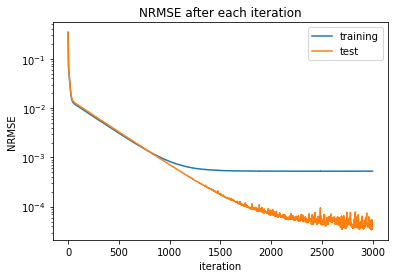

CPU times: user 9.01 s, sys: 6.45 s, total: 15.5 s
Wall time: 8.11 s


In [16]:
%time run_sgd()

## Least squares

In [ ]:
LS_REG_TERM = 23299518.105153717

LS_HYPERPARAMS = [LS_REG_TERM]

def zero_or_div(a, b):
    return np.divide(a, b, 
                     out=np.zeros_like(b, dtype=float), 
                     where=b!=0)


def calc_least_squares(attributes, values, hyperparams=LS_HYPERPARAMS):
    reg_term, = hyperparams

    u, s, vh = np.linalg.svd(append_ones(attributes), full_matrices=False)
    pseudo_inverse = vh.conj().T @ np.diag(s / (s ** 2 + reg_term)) @ u.conj().T
    return pseudo_inverse @ values


def run_least_squares():
    training_attributes, training_values, test_attributes, test_values = read_dataset()

    weights = calc_least_squares(training_attributes, training_values)

    print('Least squares training NRMSE: ', nrmse(training_attributes, training_values, weights))
    print('Least squares test NRMSE: ', nrmse(test_attributes, test_values, weights))


In [ ]:
def optimize_ls():
    training_attributes, training_values, test_attributes, test_values = read_dataset()

    def function(hyperparams):
        weights = calc_least_squares(training_attributes, training_values, hyperparams)
        err = nrmse(test_attributes, test_values, weights)
        print(err, '@', hyperparams)
        return err

    reg_space = np.logspace(-1, 9)

    params = minimize(function, reg_space)
    print(params)


# optimize_ls()

In [ ]:
%time run_least_squares()

Least squares training NRMSE:  0.0005261160824825761
Least squares test NRMSE:  3.592033972292565e-05
CPU times: user 662 ms, sys: 123 ms, total: 786 ms
Wall time: 555 ms


## Evolutionary

In [ ]:
import deap.creator
import deap.base
import deap.algorithms
import deap.tools
import random

EVO_STEPS = 40
CXPB = 0.4666666666666667
MUTPB = 0.2

EVO_HYPERPARAMS = [CXPB, MUTPB, EVO_STEPS]

def calc_evo(training_attributes, training_values, attributes_count, test_attributes, test_values, hyperparams=EVO_HYPERPARAMS):
    random.seed(42)
    deap.creator.create("ErrorMin", deap.base.Fitness, weights=(-1.0,))
    deap.creator.create("Weights", list, fitness=deap.creator.ErrorMin)

    toolbox = deap.base.Toolbox()
    toolbox.register("attribute", random.random)
    toolbox.register("weights", deap.tools.initRepeat, deap.creator.Weights,
                    toolbox.attribute, n=attributes_count)
    toolbox.register("population", deap.tools.initRepeat, list, toolbox.weights)

    def evaluate_training(weights):
        return nrmse(training_attributes, training_values, np.array(weights)),

    def evaluate_test(weights):
        return nrmse(test_attributes, test_values, np.array(weights)),

    toolbox.register("mate", deap.tools.cxTwoPoint)
    toolbox.register("mutate", deap.tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
    toolbox.register("select", deap.tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate_training)

    statistics = deap.tools.Statistics()
    statistics.register('best_training', lambda pop: min(evaluate_training(wts) for wts in pop))
    statistics.register('best_test', lambda pop: min(evaluate_test(wts) for wts in pop))

    population = toolbox.population(n=50)
    CXPB, MUTPB, NGEN = hyperparams
    final_population, logbook = deap.algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=50, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=statistics, verbose=False)

    weights = np.array(toolbox.select(final_population, 1)[0])
    return weights, logbook


def run_evo():
    training_attributes, training_values, test_attributes, test_values = read_dataset()
    attributes_count = training_attributes.shape[1] + 1

    weights, logbook = calc_evo(training_attributes, training_values, attributes_count, test_attributes, test_values)

    print('Evolutionary algo training NRMSE: ', nrmse(training_attributes, training_values, weights))
    print('Evolutionary algo test NRMSE: ', nrmse(test_attributes, test_values, weights))

    plt.plot(logbook.select('best_training'), label='training')
    plt.plot(logbook.select('best_test'), label='test')
    plt.title('NRMSE of best item in population')
    plt.xlabel('iteration')
    plt.ylabel('NRMSE')
    plt.legend()
    plt.show()


In [ ]:
def optimize_evo():
    training_attributes, training_values, test_attributes, test_values = read_dataset()
    attributes_count = training_attributes.shape[1] + 1
    
    def function(hyperparams):
        weights, _ = calc_evo(training_attributes, training_values, attributes_count, test_attributes, test_values, hyperparams)
        err = nrmse(test_attributes, test_values, weights)
        print(err, '@', hyperparams)
        return err

    cxpb_space = np.linspace(0.0, 1, num=20)
    mutpb_space = np.linspace(0.0, 1, num=20)
    steps_space = [40]

    params = minimize(function, cxpb_space, mutpb_space, steps_space)
    print(params)


# optimize_evo()

Evolutionary algo training NRMSE:  0.0008852825797792552
Evolutionary algo test NRMSE:  0.0007544730918224516


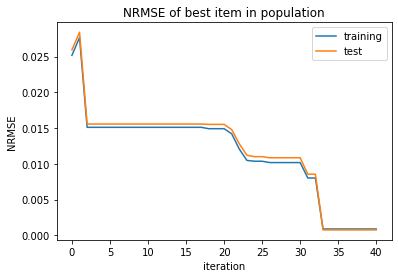

CPU times: user 9.57 s, sys: 7.52 s, total: 17.1 s
Wall time: 8.89 s


In [ ]:
%time run_evo()

## Comparison

In [ ]:
from timeit import default_timer as timer

def timed_sgd():
    training_attributes, training_values, test_attributes, test_values = prepare_sgd_data()

    start = timer()
    weights, errors, test_errors = calc_sgd(training_attributes, training_values, training_attributes.shape[1], test_attributes, test_values)
    end = timer()
    
    step_time = (end - start) / SGD_STEPS

    times = np.arange(len(test_errors)) * step_time
    plt.plot(times, test_errors, label='SGD')
    


def timed_least_squares():
    training_attributes, training_values, test_attributes, test_values = read_dataset()

    start = timer()
    weights = calc_least_squares(training_attributes, training_values)
    end = timer()

    step_time = end - start

    times = [0, step_time, 8]
    err = nrmse(test_attributes, test_values, weights)
    
    rng = np.random.Generator(np.random.PCG64(42)) 
    random_err = nrmse(test_attributes, test_values, rng.normal(size=weights.shape))

    plt.plot(times, [random_err, err, err], label='least squares')

def timed_evo():
    training_attributes, training_values, test_attributes, test_values = read_dataset()
    attributes_count = training_attributes.shape[1] + 1

    start = timer()
    weights, logbook = calc_evo(training_attributes, training_values, attributes_count, test_attributes, test_values)
    end = timer()
    
    step_time = (end - start) / EVO_STEPS

    times = np.arange(len(logbook.select('best_test'))) * step_time
    plt.plot(times, logbook.select('best_test'), label='evo')
    


def plot_timed():
    timed_sgd()
    timed_least_squares()
    timed_evo()

    plt.title('NRMSE over time')
    plt.xlabel('time in seconds')
    plt.ylabel('NRMSE')
    plt.yscale('log')
    plt.legend()

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'ErrorMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Weights' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


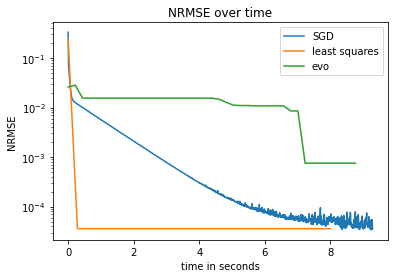

In [ ]:
plot_timed()